# Amazon Review Sentiment Analysis with NLP

## Problem Statement
The purpose of this analysis is to build a prediction model to predict the sentiment of the review in the Amazon Fine Food Review Dataset; in other words, to predict if the review has positive or negative sentiment.  This is a binary classification problem with NLP.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import re
from tabulate import tabulate

import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

## 1. Prepare Data

### 1.1. Import Data

In [4]:
reviews_original = pd.read_csv('Reviews.csv')
reviews_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
reviews_original.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


### 1.2. Add Label
The value for the semantics is 'positive' if 'Score' > 3; otherwise, the semantics is 'negative'.

In [6]:
reviews = reviews_original.copy()
reviews['Sentiment'] = reviews['Score'].apply(lambda score: 'positive' if score > 3 else 'negative')
reviews.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive


### 1.3. Utility Function

#### 1.3.1. Word Cloud for Word Features

In [8]:
def show_features(features):
    print("Number of features: {}".format(len(features)))
    # plot word cloud
    wordcloud = WordCloud(collocations=False, width=1200, height=1000).generate(' '.join(features))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### 1.3.2. Performance Metrics for Classification

In [9]:
# get multiple performance metrics based on test dataset and trained classification model
def get_performance_metrics(X, y_true, clfmodel):
    y_predict = clfmodel.predict(X)   
    print('\n----------Classification Performance Evaluation----------')
    # accuracy score
    accuracy = accuracy_score(y_true, y_predict)
    print('\n==> The Accuracy Score for Classification is: {:.2f}'.format(accuracy))
    # confusion matrix
    confusion = confusion_matrix(y_true, y_predict)
    confusion = pd.DataFrame(confusion, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
    confusion['Total'] = confusion['Predicted Negative'] + confusion['Predicted Positive']
    confusion.loc['Total'] = confusion.loc['Actual Negative'] + confusion.loc['Actual Positive']
    print('\n==> Confusion Matrix: ')
    print(tabulate(confusion, headers='keys', tablefmt='psql'))
    # classification report
    print('\n==> Classification Report: ')
    clfreport = classification_report(y_true, y_predict)
    print(clfreport)
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, clfmodel.predict_proba(X)[:, 0], pos_label='negative')
    roc = pd.DataFrame({'recall': tpr, 'specificity': 1-fpr})
    ax = roc.plot(x='specificity', y='recall', figsize=(3, 3), legend=False)
    ax.set_xlim(1, 0)
    ax.set_ylim(0, 1)
    ax.plot((0, 1), (1, 0))
    ax.set_xlabel('specificity')
    ax.set_ylabel('recall')
    plt.title('ROC Curve')
    # AUC score
    auc_score = roc_auc_score([1 if y == 'negative' else 0 for y in y_true], clfmodel.predict_proba(X)[:, 0])
    print('\n==> The AUC Score for Classification is: {:.2f}'.format(auc_score))

#### 1.3.3. Grid Search with Heatmap Visualization

In [41]:
def grid_search(X, y, pipe, param_grid, scoring, cv):

    grid = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, return_train_score=True).fit(X, y)
    print('Grid Search Result\n------------------------------------------------------------------------------')
    print('Best parameter: ', grid.best_params_)
    print('Best {}: {:.2f}'.format(scoring, grid.best_score_))
    print('Best estimator: {}', grid.best_estimator_)
    
    return grid.cv_results_ 

In [103]:
def grid_search_heatmap(gs_res, param1, param2):
    df = pd.DataFrame(gs_res)
    df.rename(columns={'param_'+ param1: param1, 'param_'+ param2: param2}, inplace=True)
    res = pd.pivot_table(df, index=param1, columns=param2, values='mean_test_score', aggfunc=np.mean)
    
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(res, cmap='YlGnBu', annot=True, fmt='.3g')
    ax.set_title('Grid Search Result')
    ax.set_ylabel(param1)
    ax.set_xlabel(param2)

## 2. Data Cleaning

### 2.1. Column Transformation

#### 2.1.1. Helpfulness

In [10]:
# rename columns HelpfulnessNumerator and HelpfulnessDenominator
reviews.rename(columns={'HelpfulnessNumerator': 'VotesHelpful', 'HelpfulnessDenominator': 'VotesTotal'}, inplace=True)
# add Usefulness to indicate if the review is helpful or not
reviews['Usefulness'] = reviews.apply(lambda row: True if (row.VotesTotal > 0) and (row.VotesHelpful / row.VotesTotal > 0.6) else False, axis=1)
reviews.head(1)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment,Usefulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,True


#### 2.1.2. Unix Time

In [11]:
reviews['DateTime'] = reviews.apply(lambda row: datetime.datetime.fromtimestamp(row.Time), axis=1)
reviews.head(1)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment,Usefulness,DateTime
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,True,2011-04-26 20:00:00


### 2.2. Check Missing Values

In [12]:
# check which columns contain missing values
print('Number of rows: ', len(reviews))
reviews.isnull().any(axis=0)

Number of rows:  568454


Id              False
ProductId       False
UserId          False
ProfileName      True
VotesHelpful    False
VotesTotal      False
Score           False
Time            False
Summary          True
Text            False
Sentiment       False
Usefulness      False
DateTime        False
dtype: bool

In [13]:
# there are two columns with missing values: [ProfileName], [Summary]
# we will drop rows with missing values in [Summary], as we don't care [ProfileName]
reviews.dropna(axis=0, subset=['Summary'], inplace=True)
print('Number of rows: ', len(reviews))
reviews['Summary'].isnull().any(axis=0)

Number of rows:  568427


False

### 2.3. Check Duplicated Values

In [14]:
# check the number of duplicates
duplicates_subset = ['ProductId', 'UserId', 'Summary']
duplicates = reviews[reviews.duplicated(subset=duplicates_subset, keep=False)]
print('Number of duplicated rows:', len(duplicates))

Number of duplicated rows: 2713


In [15]:
# show examples for duplicates
duplicates.head(2)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment,Usefulness,DateTime
466,467,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0,0,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",positive,False,2009-01-11 19:00:00
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",positive,True,2009-01-11 19:00:00


In [16]:
# remove duplicates
reviews.sort_values(by=['ProductId', 'UserId', 'Summary', 'Usefulness', 'VotesTotal'], inplace=True)
reviews.drop_duplicates(subset=duplicates_subset, keep='last', inplace=True)  # keep reviews that are useful
print('Number of duplicated rows:', len(reviews[reviews.duplicated(subset=duplicates_subset, keep=False)]))
print('Number of rows: ', len(reviews))

Number of duplicated rows: 0
Number of rows:  566797


### 2.4. Rearrange Columns and Index

In [17]:
# rearrange index
reviews.sort_values('Id', inplace=True)
reviews.reset_index(drop=True, inplace=True)
# choose proper subset of columns
reviews = reviews[['Id', 'ProductId', 'UserId', 'VotesHelpful', 'VotesTotal', 'Usefulness', 'Time', 'DateTime', 'Summary', 'Text', 'Score', 'Sentiment']]
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566797 entries, 0 to 566796
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Id            566797 non-null  int64         
 1   ProductId     566797 non-null  object        
 2   UserId        566797 non-null  object        
 3   VotesHelpful  566797 non-null  int64         
 4   VotesTotal    566797 non-null  int64         
 5   Usefulness    566797 non-null  bool          
 6   Time          566797 non-null  int64         
 7   DateTime      566797 non-null  datetime64[ns]
 8   Summary       566797 non-null  object        
 9   Text          566797 non-null  object        
 10  Score         566797 non-null  int64         
 11  Sentiment     566797 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(5), object(5)
memory usage: 48.1+ MB


In [18]:
reviews.head(1)

,Id,ProductId,UserId,VotesHelpful,VotesTotal,Usefulness,Time,DateTime,Summary,Text,Score,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,True,1303862400,2011-04-26 20:00:00,Good Quality Dog Food,I have bought several of the Vitality canned d...,5,positive


In [19]:
# notice that the dataset is imbalanced
reviews['Sentiment'].value_counts()

positive    442634
negative    124163
Name: Sentiment, dtype: int64

In [20]:
print('Examples for reviews with highest score 5: ')
print(reviews[reviews.Score == 5].Summary.values[:10])
print('\nExamples for reviews with lowest score 1: ')
print(reviews[reviews.Score == 1].Summary.values[:10])

Examples for reviews with highest score 5: 
['Good Quality Dog Food' 'Great taffy'
 'Great!  Just as good as the expensive brands!' 'Wonderful, tasty taffy'
 'Yay Barley' 'Healthy Dog Food' 'The Best Hot Sauce in the World'
 'My cats LOVE this "diet" food better than their regular food'
 'Strawberry Twizzlers - Yummy' 'Lots of twizzlers, just what you expect.']

Examples for reviews with lowest score 1: 
['Not as Advertised' 'My Cats Are Not Fans of the New Food'
 'Nasty No flavor' "Don't like it" 'stale product.'
 'Warning!  WARNING!  -ALCOHOL SUGARS!' 'No Tea Flavor' 'Bad'
 'Rip off Price' 'Tasteless but low calorie']


## 3. Split Train-Valid Data and Test Data

In [21]:
X = reviews['Summary'].values
y = reviews['Sentiment'].values

print('X - shape: ', X.shape)
print('X - one example: ', X[0])
print('y - shape: ', y.shape)
print('y - one example: ', y[0])

X - shape:  (566797,)
X - one example:  Good Quality Dog Food
y - shape:  (566797,)
y - one example:  positive


In [22]:
# the test data will only be used for the testing at the end
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2) # stratified by the labels

print('The nubmer of the records in the training set: ', X_trainval.shape[0])
print('The nubmer of the records in the test set: ', X_test.shape[0])

The nubmer of the records in the training set:  453437
The nubmer of the records in the test set:  113360


## 4. Feature Engineering (Train-Valid Data)

### 4.1. Bag-of-Words
- We can see there are some characters that are not meaningful including numbers

In [23]:
# try Unigram
cntvect = CountVectorizer().fit(X_trainval)
features = cntvect.get_feature_names_out()
print('Feature first 20: ', features[:20])
print('Feature examples: ', features[np.arange(3000, 5000, 100)])
print('Feature last 20: ', features[-20:])

Feature first 20:  ['00' '000' '0000' '001' '008' '0099' '00am' '00g' '00pm' '02' '03' '04'
 '05' '05oz' '06' '0610' '06202' '0625' '0631' '06sep12']
Feature examples:  ['birding' 'blaming' 'bloody' 'bolets' 'bore' 'bp' 'breastfed' 'briton'
 'btt' 'bulls' 'butcher' 'caesar' 'camelbak' 'capacino' 'cardiac' 'case'
 'cavendar' 'cesaly' 'chardonnay' 'cheesemaking']
Feature last 20:  ['zow' 'zowie' 'zqueen' 'zsweet' 'zu' 'zucchini' 'zuke' 'zukes' 'zupreem'
 'zushi' 'zweibach' 'zwieback' 'zylitol' 'zym' 'zz' 'zzfantastic' 'zzzzs'
 'zzzzz' 'zzzzzzzzz' 'åwesome']


Number of features: 30309


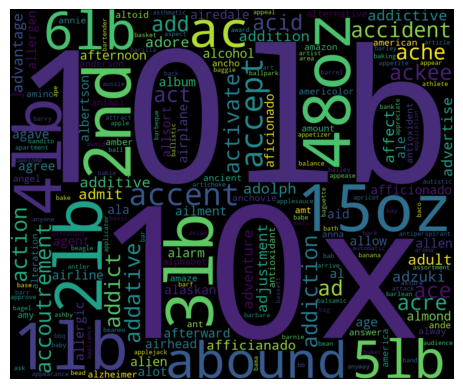

In [24]:
show_features(features)

### 4.2. Tokenization: Stopwords, Stemming, Lemmatization, ...
- We can see more meaningful words after applying custom tokenization

In [25]:
def custom_tokenizer(document):
    doc_re = re.findall('[a-zA-Z]{2,}', document)  # only keep alphabetic characters
    stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [stemmer.stem(lemmatizer.lemmatize(token)) for token in doc_re] # stemming and lemmatization

cntvect = CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5).fit(X_trainval)
features = cntvect.get_feature_names_out()
print('Feature first 20: ', features[:20])
print('Feature examples: ', features[np.arange(3000, 5000, 100)])
print('Feature last 20: ', features[-20:])

Feature first 20:  ['aa' 'aaa' 'ab' 'abbey' 'abbi' 'abc' 'abil' 'abit' 'abl' 'abolut'
 'abomin' 'aboslut' 'abound' 'abov' 'absinth' 'absolut' 'absolutley'
 'absolutli' 'absorb' 'absot']
Feature examples:  ['haribo' 'higgin' 'hout' 'incens' 'invest' 'joey' 'kiki' 'lansinoh'
 'lightn' 'lousi' 'maltodextrin' 'meal' 'milder' 'mom' 'mystic' 'noir'
 'occupi' 'orijen' 'panni' 'pen']
Feature last 20:  ['zing' 'zinger' 'zingi' 'zip' 'zipfizz' 'zipper' 'zippi' 'ziti' 'ziwi'
 'ziwipeak' 'zoe' 'zola' 'zone' 'zoo' 'zoom' 'zot' 'zotz' 'zowi' 'zsweet'
 'zuke']


Number of features: 7642


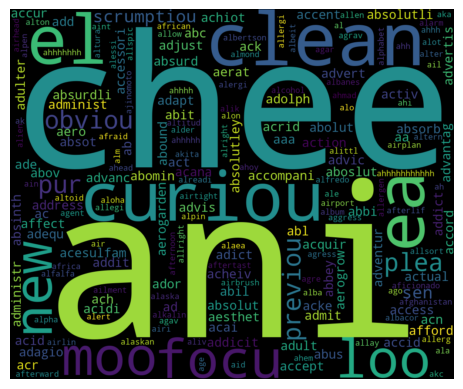

In [26]:
show_features(features)

### 4.3. TF-IDF: Data Rescaling
- The features with lowest idf actually makes more sense for sentiment

In [29]:
tfidfvect = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5).fit(X_trainval)

features = np.array(tfidfvect.get_feature_names_out())
idx_sorted_by_idf = np.argsort(tfidfvect.idf_)
print("Number of features: {}".format(len(features)))
print("Features with lowest idf:\n{}".format(features[idx_sorted_by_idf[:30]]))
print("Features with highest idf:\n{}".format(features[idx_sorted_by_idf[-30:]]))

Number of features: 7642
Features with lowest idf:
['great' 'good' 'love' 'best' 'tast' 'coffe' 'thi' 'tea' 'product' 'dog'
 'delici' 'flavor' 'veri' 'like' 'food' 'excel' 'price' 'tasti' 'yummi'
 'cat' 'treat' 'favorit' 'snack' 'stuff' 'cup' 'better' 'just' 'healthi'
 'chocol' 'free']
Features with highest idf:
['gastrointestin' 'burp' 'tacki' 'geber' 'buonissimo' 'tahina' 'taho'
 'tai' 'organic' 'organi' 'tampanad' 'tamper' 'gentli' 'bulgur' 'orbana'
 'opportun' 'oper' 'gfcfefsf' 'tarragon' 'gfree' 'task' 'taste'
 'bronchipret' 'tastig' 'gibson' 'tats' 'onecup' 'giggl' 'flush'
 'differenet']


### 4.4. n-Grams
- Bigram can also show meaningful words for sentiment
- We will grid search different n-Grams models later

In [30]:
# try Bigram
tfidfvect = TfidfVectorizer(ngram_range=(2, 2), tokenizer=custom_tokenizer, stop_words='english', min_df=5).fit(X_trainval)

features = np.array(tfidfvect.get_feature_names_out())
idx_sorted_by_idf = np.argsort(tfidfvect.idf_)
print("Number of features: {}".format(len(features)))
print("Features with lowest idf:\n{}".format(features[idx_sorted_by_idf[:30]]))
print("Features with highest idf:\n{}".format(features[idx_sorted_by_idf[-30:]]))

Number of features: 27902
Features with lowest idf:
['love thi' 'great product' 'dog love' 'great tast' 'veri good'
 'gluten free' 'great coffe' 'great price' 'dog food' 'tast great'
 'good stuff' 'cat love' 'thi stuff' 'tast like' 'good product'
 'good coffe' 'pretti good' 'tast good' 'green tea' 'great tea'
 'great flavor' 'thi product' 'good tast' 'cat food' 'excel product'
 'great snack' 'good price' 'veri tasti' 'cup coffe' 'great stuff']
Features with highest idf:
['salti dog' 'bone medium' 'bone make' 'grreat biscotti' 'bold veri'
 'grrrrrrreat tast' 'gu energi' 'bon comm' 'salt stick' 'guess minor'
 'guest favorit' 'salt salt' 'salt review' 'salt product' 'bone best'
 'delici dress' 'salt jerki' 'guinea pig' 'bone differ' 'bone good'
 'salt compani' 'bone lb' 'salt chang' 'salt block' 'salt blend'
 'gum cinnamon' 'gum gluten' 'salt alaea' 'salsa verd' 'expens conveni']


## 5. Model Building and Selection (Train-Valid Data)

### 5.1. Base Model and Initial Evaluation
- The base model gets good accuracy score (0.87) and AUC score (0.89)
- However, **macro-averaged f1-score (0.78)** is lower, and recall (0.54) and specificity (0.96) is very different, due to imbalanced dataset
- To make sure the chosen classfier is effective for both positive and negative reviews, we would use **macro-averaged f1-scoree** for later model selection
- No major overfitting issues observed from the cross validation result

#### 5.1.1. Build Base Model

In [31]:
# split the train and valid dataset
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, stratify=y_trainval, random_state=1, test_size=0.2)
print('The nubmer of the records in the train data set: ', X_train.shape[0])
print('The nubmer of the records in the valid data set: ', X_valid.shape[0])

The nubmer of the records in the train data set:  362749
The nubmer of the records in the valid data set:  90688


In [32]:
# bag-of-words transformation
cntvect = CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5)
X_train_cntvect = cntvect.fit_transform(X_train)
# build logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_cntvect, y_train)
print('The accuracy score of the training dataset: {:.2f}'.format(logreg.score(X_train_cntvect, y_train)))

The accuracy score of the training dataset: 0.87


#### 5.1.2. Performance Metrics



----------Classification Performance Evaluation----------

==> The Accuracy Score for Classification is: 0.87

==> Confusion Matrix: 
+-----------------+----------------------+----------------------+---------+
|                 |   Predicted Negative |   Predicted Positive |   Total |
|-----------------+----------------------+----------------------+---------|
| Actual Negative |                10729 |                 9137 |   19866 |
| Actual Positive |                 2826 |                67996 |   70822 |
| Total           |                13555 |                77133 |   90688 |
+-----------------+----------------------+----------------------+---------+

==> Classification Report: 
              precision    recall  f1-score   support

    negative       0.79      0.54      0.64     19866
    positive       0.88      0.96      0.92     70822

    accuracy                           0.87     90688
   macro avg       0.84      0.75      0.78     90688
weighted avg       0.86      0.8

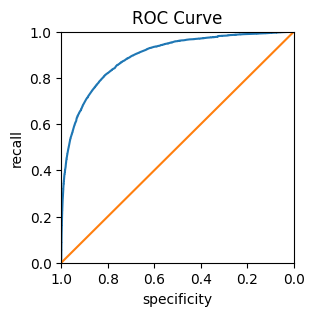

In [33]:
X_valid_cntvect = cntvect.transform(X_valid)
get_performance_metrics(X_valid_cntvect, y_valid, logreg)

#### 5.1.3. Generalization Performance with Cross Validation

In [37]:
pipe = Pipeline([('countvectorizer', CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5)),
                 ('logisticregression', LogisticRegression())])
res_df = pd.DataFrame(cross_validate(pipe, X_trainval, y_trainval, cv=5, return_train_score=True, scoring = 'f1_macro'))
print('\nMean macro-averaged f1-score of cross validation results: {:.2f}'.format(res_df['test_score'].mean()))
res_df


Mean macro-averaged f1-score of cross validation results: 0.78


,fit_time,score_time,test_score,train_score
0,33.437590,8.618434,0.781953,0.791551
1,34.460369,8.416952,0.783646,0.790282
2,33.420254,8.485064,0.780852,0.790645
3,33.500732,8.365548,0.780768,0.790280
4,34.866058,8.876405,0.782885,0.790264


### 5.2. Model: Logistic Regression
Best logistic regression model with **macro-averaged f1-score (0.82)**
- TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5, ngram_range=(1, 2))
- LogisticRegression(C=10))

#### 5.2.1. Grid Search for Model Selection

- **CountVectorizer**
- From grid search result, including both unigram and bigram clearly provides better performance
- Only bigram does not perform well
- Let's try including more n-grams later

Grid Search Result
------------------------------------------------------------------------------
Best parameter:  {'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 10}
Best f1_macro: 0.82
Best estimator: {} Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words='english',
                                 tokenizer=<function custom_tokenizer at 0x0000018910EB8540>)),
                ('logisticregression', LogisticRegression(C=10))])
CPU times: total: 35min 55s
Wall time: 33min 16s


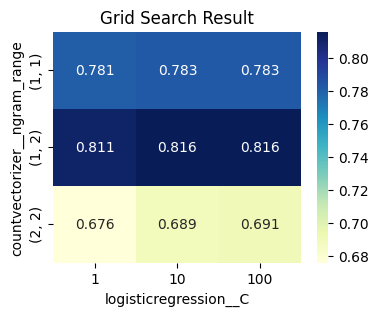

In [104]:
pipe = Pipeline([('countvectorizer', CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5)),
                 ('logisticregression', LogisticRegression())])

param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
              'logisticregression__C': [1, 10, 100]}

%time gs_cntvect_logreg = grid_search(X=X_trainval, y=y_trainval, pipe=pipe, param_grid=param_grid, scoring='f1_macro', cv=3)
# visualize result
grid_search_heatmap(gs_res=gs_cntvect_logreg, param1='countvectorizer__ngram_range', param2='logisticregression__C')

- **TfidfVectorizer**
- Two vectorizers (CountVectorizer, TfidfVectorizer) provides similar results
- Including 3-grams slightly improve the performance, but we would go for (1, 2)-grams for the efficient computation and avoiding overfitting

Grid Search Result
------------------------------------------------------------------------------
Best parameter:  {'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 3)}
Best f1_macro: 0.82
Best estimator: {} Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words='english',
                                 tokenizer=<function custom_tokenizer at 0x0000018910EB8540>)),
                ('logisticregression', LogisticRegression(C=10))])
CPU times: total: 36min 50s
Wall time: 34min 44s


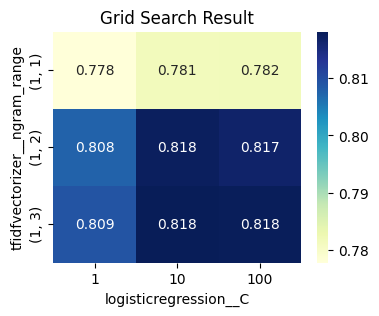

In [105]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5)),
                 ('logisticregression', LogisticRegression())])

param_grid = {'tfidfvecStorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'logisticregression__C': [1, 10, 100]}

%time gs_tfidfvect_logreg = grid_search(X=X_trainval, y=y_trainval, pipe=pipe, param_grid=param_grid, scoring='f1_macro', cv=3)
# visualize result
grid_search_heatmap(gs_res=gs_tfidfvect_logreg, param1='tfidfvectorizer__ngram_range', param2='logisticregression__C')

In [124]:
# looks into overfitting
# no major overfitting issue observed
pd.DataFrame(gs_tfidfvect_logreg)[['param_tfidfvectorizer__ngram_range', 'param_logisticregression__C',
                                   'mean_test_score', 'mean_train_score']]

,param_tfidfvectorizer__ngram_range,param_logisticregression__C,mean_test_score,mean_train_score
0,"(1, 1)",1,0.777795,0.785947
1,"(1, 2)",1,0.807612,0.824062
2,"(1, 3)",1,0.809193,0.826297
3,"(1, 1)",10,0.781420,0.792278
4,"(1, 2)",10,0.817560,0.843504
5,"(1, 3)",10,0.818136,0.845681
6,"(1, 1)",100,0.781710,0.792873
7,"(1, 2)",100,0.816594,0.844222
8,"(1, 3)",100,0.817910,0.847849


#### 5.2.2. Best Logistic Regression Model with Feature Importance

- **Train Best Logistic Regression Model on Train-Valid Dataset**

In [130]:
pipe_best_logreg = Pipeline([('tfidfvectorizer', TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5, ngram_range=(1, 2))),
                             ('logisticregression', LogisticRegression(C=10))])
pipe_best_logreg.fit(X_trainval, y_trainval)
print('Score of train-valid dataset: {:.2f}'.format(f1_score(y_trainval, pipe_best_logreg.predict(X_trainval), average='macro')))

Score of train-valid dataset: 0.84


- **Feature Importance Visualization**
- We can see that some top words include two words, which explains including bigram can improve performance in the above results

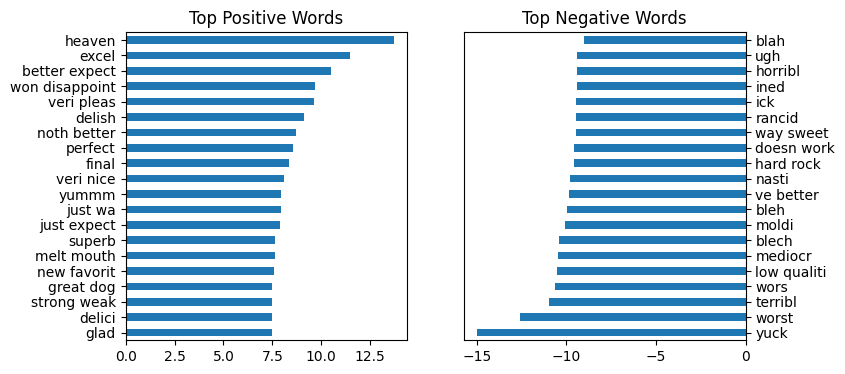

In [131]:
tfidfvect, logreg = pipe_best_logreg.named_steps['tfidfvectorizer'], pipe_best_logreg.named_steps['logisticregression']

df = pd.DataFrame()
df['Feature'] = tfidfvect.get_feature_names_out()
df['Coef'] = logreg.coef_[0]
df.sort_values('Coef', inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# for positive sentiment
df.tail(20).plot(ax=axes[0], x='Feature', y='Coef', kind='barh', legend=False)
axes[0].set_title('Top Positive Words')
axes[0].set_ylabel('')
# for negative sentiment
df.head(20).plot(ax=axes[1], x='Feature', y='Coef', kind='barh', legend=False)
axes[1].set_title('Top Negative Words')
axes[1].set_ylabel('')
axes[1].yaxis.tick_right()

### 5.3. Model: Random Forest Classifier

Best random forest model with **macro-averaged f1-score (0.81)**
- TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5, ngram_range=(1, 1))
- RandomForestClassifier(random_state=0, n_estimators=50, min_samples_leaf=2)

#### 5.3.1. Grid Search for Model Selection

- **CountVectorizer**
- Less min_samples_leaf in the random forest classifier clearly provides a better performance, but **overfitting** issue observed
- n-grams (1, 3) provides best score, but different n-grams provides almost similar performance as unigram; we go for unigram moving forward for efficient computation

Grid Search Result
------------------------------------------------------------------------------
Best parameter:  {'countvectorizer__ngram_range': (1, 3), 'randomforestclassifier__min_samples_leaf': 1}
Best f1_macro: 0.84
Best estimator: {} Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words='english',
                                 tokenizer=<function custom_tokenizer at 0x0000018910EB8540>)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=50, random_state=0))])
CPU times: total: 4h 32min 46s
Wall time: 4h 40min 19s


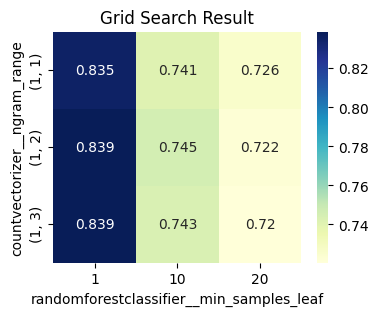

In [116]:
pipe = Pipeline([('countvectorizer', CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5)),
                 ('randomforestclassifier', RandomForestClassifier(random_state=0, n_estimators=50))])

param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'randomforestclassifier__min_samples_leaf': [1, 10, 20]}

%time gs_cntvect_rf = grid_search(X=X_trainval, y=y_trainval, pipe=pipe, param_grid=param_grid, scoring='f1_macro', cv=3)
# visualize result
grid_search_heatmap(gs_res=gs_cntvect_rf, param1='countvectorizer__ngram_range', param2='randomforestclassifier__min_samples_leaf')

In [120]:
# looks into overfitting
# overfitting issues observed for the best estimator {'randomforestclassifier__min_samples_leaf': 1}
pd.DataFrame(gs_cntvect_rf)[['param_countvectorizer__ngram_range', 'param_randomforestclassifier__min_samples_leaf', 'mean_test_score', 'mean_train_score']]

,param_countvectorizer__ngram_range,param_randomforestclassifier__min_samples_leaf,mean_test_score,mean_train_score
0,"(1, 1)",1,0.835290,0.938143
1,"(1, 1)",10,0.741196,0.745627
2,"(1, 1)",20,0.725735,0.728255
3,"(1, 2)",1,0.838602,0.940678
4,"(1, 2)",10,0.745399,0.750256
5,"(1, 2)",20,0.722075,0.725257
6,"(1, 3)",1,0.838768,0.940655
7,"(1, 3)",10,0.743252,0.748252
8,"(1, 3)",20,0.720419,0.723149


In [132]:
# try {'randomforestclassifier__min_samples_leaf': 2}
pipe = Pipeline([('countvectorizer', CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5, ngram_range=(1, 3))),
                 ('randomforestclassifier', RandomForestClassifier(random_state=0, n_estimators=50, min_samples_leaf=2))])

%time cv_cntvect_rf = pd.DataFrame(cross_validate(pipe, X_trainval, y_trainval, cv=5, return_train_score=True, scoring = 'f1_macro'))
print('\nMean macro-averaged f1-score of cross validation results: {:.2f}'.format(cv_cntvect_rf['test_score'].mean()))
cv_cntvect_rf

CPU times: total: 26min 36s
Wall time: 27min 40s

Mean macro-averaged f1-score of cross validation results: 0.80


,fit_time,score_time,test_score,train_score
0,237.990610,16.093342,0.796982,0.818544
1,246.884986,17.423119,0.799089,0.818240
2,255.557825,16.490412,0.797719,0.819703
3,257.717411,16.414424,0.796695,0.818624
4,246.249698,16.396795,0.798102,0.818436


In [127]:
# try {'randomforestclassifier__min_samples_leaf': 3}
pipe = Pipeline([('countvectorizer', CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5, ngram_range=(1, 3))),
                 ('randomforestclassifier', RandomForestClassifier(random_state=0, n_estimators=50, min_samples_leaf=3))])

%time cv_cntvect_rf = pd.DataFrame(cross_validate(pipe, X_trainval, y_trainval, cv=5, return_train_score=True, scoring = 'f1_macro'))
print('\nMean macro-averaged f1-score of cross validation results: {:.2f}'.format(cv_cntvect_rf['test_score'].mean()))
cv_cntvect_rf

CPU times: total: 19min 42s
Wall time: 20min 29s

Mean macro-averaged f1-score of cross validation results: 0.79


,fit_time,score_time,test_score,train_score
0,170.865831,15.751533,0.786093,0.801174
1,175.631618,15.574330,0.788607,0.802235
2,164.740735,15.151734,0.786952,0.801773
3,169.079498,14.714099,0.785965,0.801511
4,161.127440,15.003002,0.787101,0.801379


- **TfidfVectorizer**
- Due to the time limit, we won't run grid search in this section, instead will try few cases with cross validation based on best guesses from above running results

In [129]:
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5, ngram_range=(1, 1))),
                 ('randomforestclassifier', RandomForestClassifier(random_state=0, n_estimators=50, min_samples_leaf=2))])

%time cv_tfidfvect_rf = pd.DataFrame(cross_validate(pipe, X_trainval, y_trainval, cv=5, return_train_score=True, scoring = 'f1_macro'))
print('\nMean macro-averaged f1-score of cross validation results: {:.2f}'.format(cv_tfidfvect_rf['test_score'].mean()))
cv_tfidfvect_rf

CPU times: total: 26min 47s
Wall time: 27min 28s

Mean macro-averaged f1-score of cross validation results: 0.81


,fit_time,score_time,test_score,train_score
0,253.006804,14.756161,0.813523,0.843612
1,254.545556,15.524607,0.815324,0.843984
2,253.039151,15.037572,0.815271,0.844398
3,249.200708,15.271758,0.811514,0.843613
4,254.720884,15.195992,0.814385,0.844915


#### 5.3.2. Best Random Forest Model with Feature Importance

- **Train Best Random Forest Model on Train-Valid Dataset**

In [133]:
pipe_best_rf = Pipeline([('tfidfvectorizer', TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5, ngram_range=(1, 1))),
                         ('randomforestclassifier', RandomForestClassifier(random_state=0, n_estimators=50, min_samples_leaf=2))])
pipe_best_rf.fit(X_trainval, y_trainval)
print('Score of train-valid dataset: {:.2f}'.format(f1_score(y_trainval, pipe_best_rf.predict(X_trainval), average='macro')))

Score of train-valid dataset: 0.85


- **Feature Importance Visualization**

Text(0, 0.5, '')

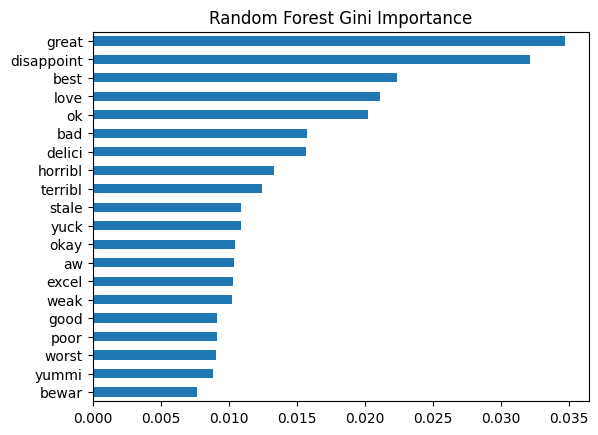

In [140]:
tfidfvect, rf = pipe_best_rf.named_steps['tfidfvectorizer'], pipe_best_rf.named_steps['randomforestclassifier']

df = pd.DataFrame()
df['Feature'] = tfidfvect.get_feature_names_out()
df['Gini Importance'] = rf.feature_importances_
df.sort_values('Gini Importance', inplace=True)

ax = df.tail(20).plot(kind='barh', x='Feature', y='Gini Importance', legend=False)
ax.set_title('Random Forest Gini Importance')
ax.set_ylabel('')

## 6. Model Testing and Performance Evaluation (Test Data)
As shown above, below is the best model we would choose with **macro-averaged f1-score (0.82)** in the Train-Valid data
- **TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english', min_df=5, ngram_range=(1, 2))**
- **LogisticRegression(C=10))**

From the performance evaluation in the Test data
- the best model achieves **macro-averaged f1-score 0.82** in the test data, which is similar to in the train-valid data; the prediction is robust and no overfitting happens
- compared to the initial base model, the macro-averaged f1-score is higher (0.82>0.78), and the recall for the negative reviews is higher as well (0.64 >0.54), which shows a more balanced performance in the imbalanced dataset
- compared to the initial base model, both **accuracy score 0.89** (>0.87) and **AUC score 0.92** (>0.89) are slightly higher, which shows the improvement by involving bigram in the logistic regression


----------Classification Performance Evaluation----------

==> The Accuracy Score for Classification is: 0.89

==> Confusion Matrix: 
+-----------------+----------------------+----------------------+---------+
|                 |   Predicted Negative |   Predicted Positive |   Total |
|-----------------+----------------------+----------------------+---------|
| Actual Negative |                15789 |                 9044 |   24833 |
| Actual Positive |                 3540 |                84987 |   88527 |
| Total           |                19329 |                94031 |  113360 |
+-----------------+----------------------+----------------------+---------+

==> Classification Report: 
              precision    recall  f1-score   support

    negative       0.82      0.64      0.72     24833
    positive       0.90      0.96      0.93     88527

    accuracy                           0.89    113360
   macro avg       0.86      0.80      0.82    113360
weighted avg       0.88      0.8

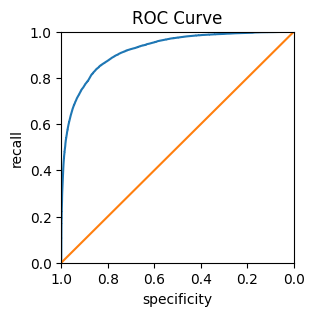

In [141]:
tfidfvect, logreg = pipe_best_logreg.named_steps['tfidfvectorizer'], pipe_best_logreg.named_steps['logisticregression']
X_test_tfidfvect = tfidfvect.transform(X_test)
get_performance_metrics(X_test_tfidfvect, y_test, logreg)